# Model Training and Assessment

In [47]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm

# my modules
from dataloader import SneakerDataset
from model import Net

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## Training and Validation Helper Functions

In [26]:
def train(model, dataloader, criterion, optimizer):

    model.train()
        
    train_running_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels in tqdm(dataloader):
        
        # store in GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # pass through model, compute CE loss 
        predictions = model(inputs)
        loss = criterion(predictions, labels)
        optimizer.zero_grad()
        loss.backward()
        
        # step after weight update 
        optimizer.step()

        train_correct += (predictions.argmax(dim=1) == labels).float().sum().detach().cpu()
        train_running_loss += loss.item()
        train_total += len(labels)
        
    avg_train_acc = train_correct / train_total
    avg_train_loss = train_running_loss/len(dataloader)
    
    return avg_train_loss, avg_train_acc
    
def test(model, dataloader, criterion):
    
    # testing 
    model.eval()
    with torch.no_grad():
        test_running_loss = 0.0
        test_correct = 0
        test_total = 0
        
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # pass through model 
            predictions = model(inputs)
            loss = criterion(predictions, labels)

            # compute accacy and loss 
            test_running_loss += loss.item()
            test_correct += (predictions.argmax(dim=1) == labels).float().sum().detach().cpu().item()
            test_total += len(labels)
            
    avg_test_acc = test_correct / test_total
    avg_test_loss = test_running_loss/len(dataloader)
    
    return avg_test_loss, avg_test_acc


In [27]:
# random seed
torch.manual_seed(42)

# GPU 
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print(device)    

# normalize images
mean = [0.5, 0.5, 0.5]
std =  [0.5, 0.5, 0.5]    

# sequence of image transformations for training
train_transform = transforms.Compose([
    transforms.RandomApply([transforms.RandomRotation(30)], p=0.5), 
    transforms.RandomHorizontalFlip(),                      
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

# sequence of image transformations for testing
test_transform = transforms.Compose([          
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

# init dataset and dataloaders
train_dataset = SneakerDataset('train', transform=train_transform)
test_dataset = SneakerDataset('test', transform=test_transform)
train_loader = DataLoader(dataset = train_dataset, batch_size = 64, shuffle = True)
test_loader = DataLoader(dataset = test_dataset, batch_size = 32, shuffle = True)

cuda


In [28]:
sneaker_dict = {0: "555088-105", 
     1: "555088-126",
     2: "555088-500",
     3: "555088-711",
     4: "DC1788-100",
     5: "DD9335-641",
     6: "DO7097-100",
     7: "DZ5485-031",
     8: "DZ5485-400",
     9: "DZ5485-612"
    }

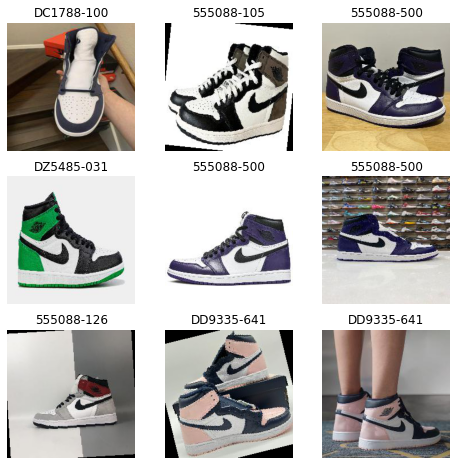

In [29]:
# plot images

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
torch.manual_seed(42)
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.title(sneaker_dict[label])
    plt.imshow(img.permute(1, 2, 0)*0.5 + 0.5)

## Training Model

In [30]:
# plotting purposes
train_accs_list = []
test_accs_list = []
train_loss_list = []
test_loss_list = []

# init model and hyperparameters
model = Net().to(device)
# cross entropy loss
criterion = nn.CrossEntropyLoss()
epochs = 20
# adam optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# training and validation loop

for epoch in range(epochs):
    # TRAINING
    running_loss, running_accuracy = train(model, train_loader, criterion, optimizer)
    train_accs_list.append(running_accuracy)
    train_loss_list.append(running_loss)

    test_loss, test_accuracy = test(model, test_loader, criterion)
    print(f"[Epoch: {epoch+1}] train acc: {running_accuracy:.4f} || train loss: {running_loss:.4f} || test acc: {test_accuracy:.4f} || test loss: {test_loss:.4f}")
    test_accs_list.append(test_accuracy)
    test_loss_list.append(test_loss)   

100%|██████████| 16/16 [00:01<00:00, 11.27it/s]


[Epoch: 1] train acc: 0.2151 || train loss: 2.8653 || test acc: 0.3231 || test loss: 2.0326


100%|██████████| 16/16 [00:01<00:00, 14.97it/s]


[Epoch: 2] train acc: 0.4723 || train loss: 1.6221 || test acc: 0.5358 || test loss: 1.4771


100%|██████████| 16/16 [00:01<00:00, 14.97it/s]


[Epoch: 3] train acc: 0.6339 || train loss: 1.1783 || test acc: 0.6278 || test loss: 1.1685


100%|██████████| 16/16 [00:01<00:00, 14.76it/s]


[Epoch: 4] train acc: 0.6681 || train loss: 0.9943 || test acc: 0.6319 || test loss: 1.0403


100%|██████████| 16/16 [00:01<00:00, 14.75it/s]


[Epoch: 5] train acc: 0.7656 || train loss: 0.7896 || test acc: 0.6871 || test loss: 1.0054


100%|██████████| 16/16 [00:01<00:00, 14.47it/s]


[Epoch: 6] train acc: 0.7937 || train loss: 0.6654 || test acc: 0.7362 || test loss: 0.8574


100%|██████████| 16/16 [00:01<00:00, 14.60it/s]


[Epoch: 7] train acc: 0.8200 || train loss: 0.5868 || test acc: 0.7689 || test loss: 0.8044


100%|██████████| 16/16 [00:01<00:00, 13.55it/s]


[Epoch: 8] train acc: 0.8780 || train loss: 0.4677 || test acc: 0.7853 || test loss: 0.7266


100%|██████████| 16/16 [00:01<00:00, 15.08it/s]


[Epoch: 9] train acc: 0.8701 || train loss: 0.4592 || test acc: 0.7546 || test loss: 0.7626


100%|██████████| 16/16 [00:01<00:00, 14.59it/s]


[Epoch: 10] train acc: 0.8920 || train loss: 0.4083 || test acc: 0.8221 || test loss: 0.7059


100%|██████████| 16/16 [00:01<00:00, 14.83it/s]


[Epoch: 11] train acc: 0.8938 || train loss: 0.3737 || test acc: 0.8139 || test loss: 0.6502


100%|██████████| 16/16 [00:01<00:00, 14.49it/s]


[Epoch: 12] train acc: 0.9043 || train loss: 0.3326 || test acc: 0.8241 || test loss: 0.6684


100%|██████████| 16/16 [00:01<00:00, 12.90it/s]


[Epoch: 13] train acc: 0.8964 || train loss: 0.3325 || test acc: 0.8303 || test loss: 0.6011


100%|██████████| 16/16 [00:01<00:00, 12.60it/s]


[Epoch: 14] train acc: 0.9298 || train loss: 0.2588 || test acc: 0.8323 || test loss: 0.6102


100%|██████████| 16/16 [00:01<00:00, 12.31it/s]


[Epoch: 15] train acc: 0.9350 || train loss: 0.2291 || test acc: 0.8507 || test loss: 0.6277


100%|██████████| 16/16 [00:01<00:00, 13.36it/s]


[Epoch: 16] train acc: 0.9306 || train loss: 0.2469 || test acc: 0.8446 || test loss: 0.6019


100%|██████████| 16/16 [00:01<00:00, 13.58it/s]


[Epoch: 17] train acc: 0.9438 || train loss: 0.2256 || test acc: 0.8446 || test loss: 0.5673


100%|██████████| 16/16 [00:01<00:00, 12.79it/s]


[Epoch: 18] train acc: 0.9535 || train loss: 0.1849 || test acc: 0.8466 || test loss: 0.5484


100%|██████████| 16/16 [00:01<00:00, 12.15it/s]


[Epoch: 19] train acc: 0.9535 || train loss: 0.1791 || test acc: 0.8425 || test loss: 0.5509


100%|██████████| 16/16 [00:01<00:00, 14.13it/s]

[Epoch: 20] train acc: 0.9596 || train loss: 0.1471 || test acc: 0.8609 || test loss: 0.5858


## Training and Validation Curves

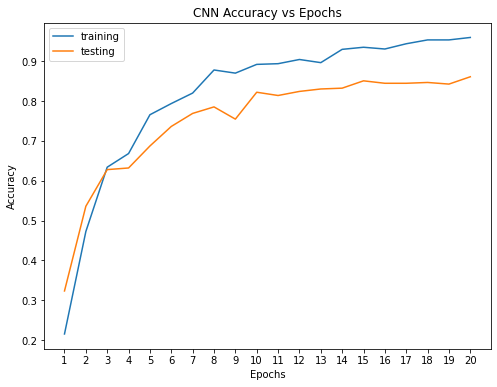

In [37]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, epochs + 1), np.array(train_accs_list), label = "training")
plt.plot(np.arange(1, epochs + 1), np.array(test_accs_list), label = "testing")
plt.xticks(range(1, epochs + 1))
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("CNN Accuracy vs Epochs")
plt.legend()
plt.show()

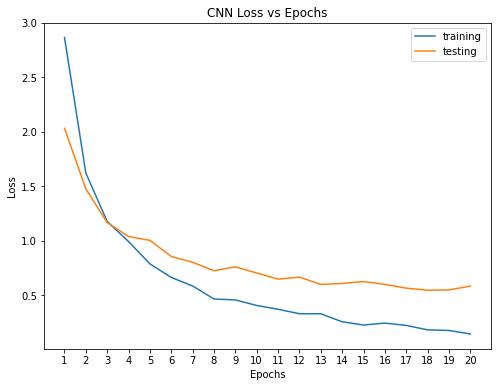

In [38]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, epochs + 1), np.array(train_loss_list), label = "training")
plt.plot(np.arange(1, epochs + 1), np.array(test_loss_list), label = "testing")
plt.xticks(range(1, epochs + 1))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("CNN Loss vs Epochs")
plt.legend()
plt.show()

In [54]:
# with open(r'./exp/exp03/train_accs_list.txt', 'w') as fp:
#     for item in train_accs_list:
#         # write each item on a new line
#         fp.write("%s\n" % item)
#     print('Done')

# with open(r'./exp/exp03/test_accs_list.txt', 'w') as fp:
#     for item in test_accs_list:
#         # write each item on a new line
#         fp.write("%s\n" % item)
#     print('Done')

# with open(r'./exp/exp03/train_loss_list.txt', 'w') as fp:
#     for item in train_loss_list:
#         # write each item on a new line
#         fp.write("%s\n" % item)
#     print('Done')

# with open(r'./exp/exp03/test_loss_list.txt', 'w') as fp:
#     for item in test_loss_list:
#         # write each item on a new line
#         fp.write("%s\n" % item)
#     print('Done')

Done
Done
Done
Done


### Comparing Experimental Results

In [55]:
# test_accs_exp01 = []
# with open('./exp/exp01/test_accs_list.txt', 'r') as file:
#     lines = file.readlines()
#     for line in lines:
#         value = float(line.strip())
#         test_accs_exp01.append(value)

# test_loss_exp01 = []
# with open('./exp/exp01/test_loss_list.txt', 'r') as file:
#     lines = file.readlines()
#     for line in lines:
#         value = float(line.strip())
#         test_loss_exp01.append(value)
        
# test_accs_exp02 = []
# with open('./exp/exp02/test_accs_list.txt', 'r') as file:
#     lines = file.readlines()
#     for line in lines:
#         value = float(line.strip())
#         test_accs_exp02.append(value)

# test_loss_exp02 = []
# with open('./exp/exp02/test_loss_list.txt', 'r') as file:
#     lines = file.readlines()
#     for line in lines:
#         value = float(line.strip())
#         test_loss_exp02.append(value)
        
# test_accs_exp03 = []
# with open('./exp/exp03/test_accs_list.txt', 'r') as file:
#     lines = file.readlines()
#     for line in lines:
#         value = float(line.strip())
#         test_accs_exp03.append(value)

# test_loss_exp03 = []
# with open('./exp/exp03/test_loss_list.txt', 'r') as file:
#     lines = file.readlines()
#     for line in lines:
#         value = float(line.strip())
#         test_loss_exp03.append(value)

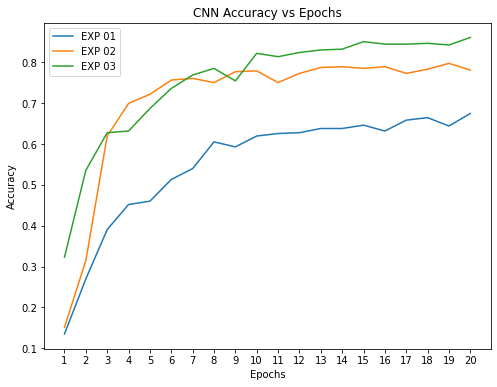

In [56]:
epochs = 20
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, epochs + 1), np.array(test_accs_exp01), label = "EXP 01")
plt.plot(np.arange(1, epochs + 1), np.array(test_accs_exp02), label = "EXP 02")
plt.plot(np.arange(1, epochs + 1), np.array(test_accs_exp03), label = "EXP 03")
plt.xticks(range(1, epochs + 1))
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("CNN Accuracy vs Epochs")
plt.legend()
plt.show()

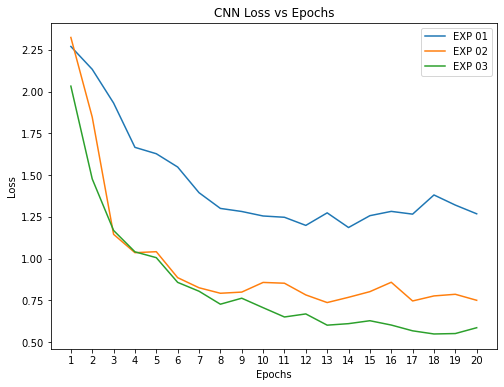

In [57]:
epochs = 20
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, epochs + 1), np.array(test_loss_exp01), label = "EXP 01")
plt.plot(np.arange(1, epochs + 1), np.array(test_loss_exp02), label = "EXP 02")
plt.plot(np.arange(1, epochs + 1), np.array(test_loss_exp03), label = "EXP 03")
plt.xticks(range(1, epochs + 1))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("CNN Loss vs Epochs")
plt.legend()
plt.show()

## Confusion Matrix

In [39]:
def cm_generator(test_loader):
    preds = []
    actual = []
    with torch.no_grad():
        for images, labels in test_loader:
            labels = labels.type(torch.LongTensor)
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            predictions = outputs.argmax(dim=1)

            preds.extend(predictions.detach().cpu().numpy())
            actual.extend(labels.detach().cpu().numpy())

    return preds, actual

In [44]:
preds, actual = cm_generator(test_loader)
confusion_matrix_df = pd.DataFrame(confusion_matrix(preds, actual))

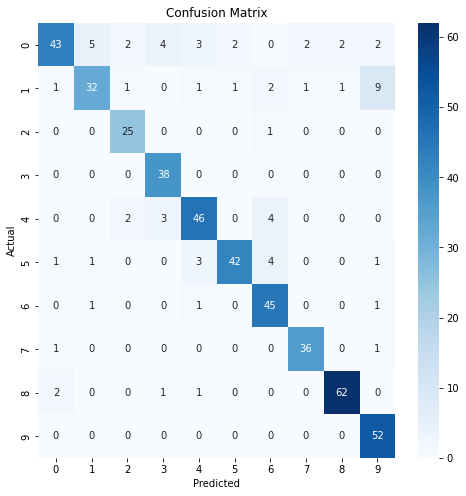

In [53]:
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix_df, annot = True, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Visualize Predictions

In [102]:
sample_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

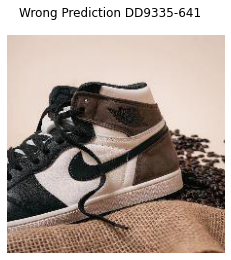

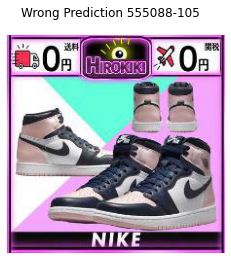

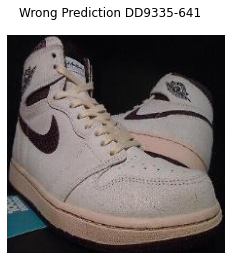

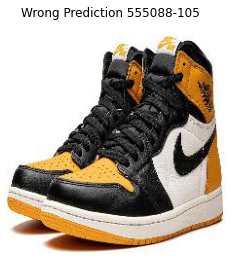

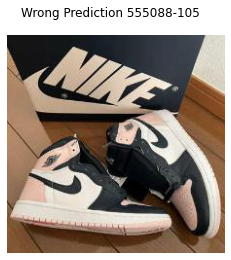

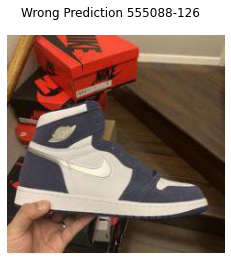

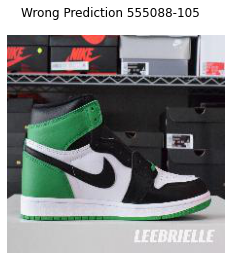

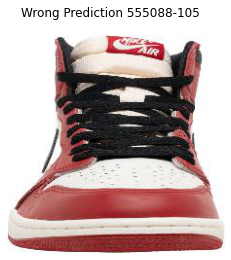

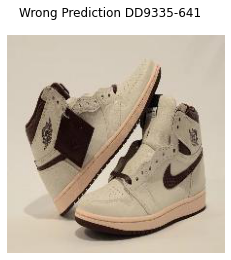

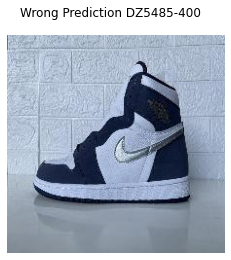

In [112]:
num_misclass = 0

for i, (x, y) in enumerate(sample_loader):

    x = x.to(device) # cuda
    y = y.to(device)
    x.requires_grad = True

    yh = model.forward(x) # output
    loss = criterion(yh, y)
    optimizer.zero_grad()
    loss.backward()

    # prediction
    _, predicted = torch.max(yh.data, 1)

    # misclassified
    if num_misclass == 10:
        break

    if (predicted != y):
        num_misclass += 1

        fig, ax = plt.subplots(1, 1)
        fig.suptitle('Wrong Prediction {}'.format(sneaker_dict[predicted.detach().cpu().numpy()[0]]))
        ax.imshow(x[0].detach().cpu().numpy().transpose((1,2,0))* 0.5 + 0.5)
        ax.axis('off')

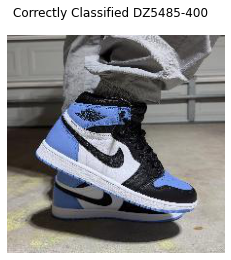

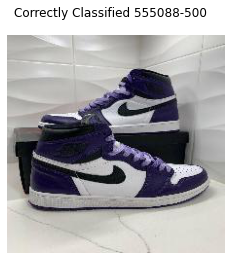

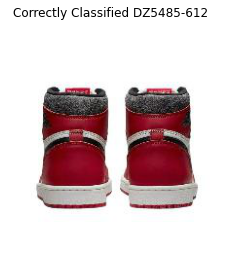

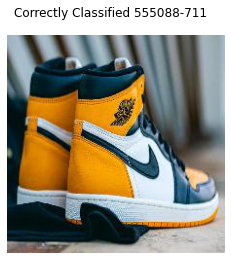

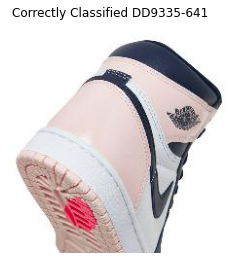

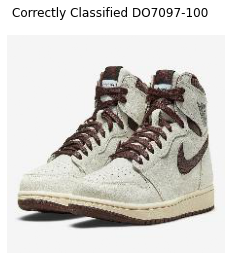

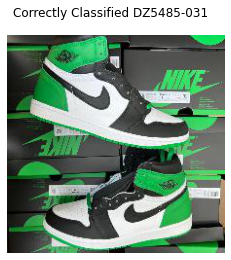

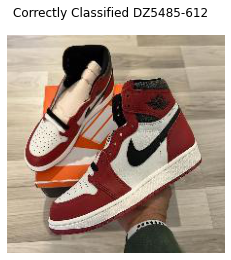

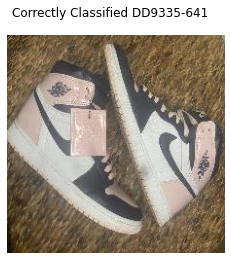

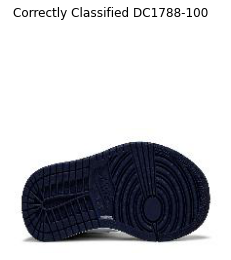

In [113]:
num_correct = 0

for i, (x, y) in enumerate(sample_loader):

    x = x.to(device) # cuda
    y = y.to(device)
    x.requires_grad = True

    yh = model.forward(x) # output
    loss = criterion(yh, y)
    optimizer.zero_grad()
    loss.backward()

    # prediction
    _, predicted = torch.max(yh.data, 1)
    
    if num_correct == 10:
        break

    if (predicted == y):
        num_correct += 1
        fig, ax = plt.subplots(1, 1)
        fig.suptitle('Correctly Classified {}'.format(sneaker_dict[predicted.detach().cpu().numpy()[0]]))
        ax.imshow(x[0].detach().cpu().numpy().transpose((1,2,0))* 0.5 + 0.5)
        ax.axis('off')